# Import Libs

In [ ]:
# import modules
import pandas as pd
import numpy as np
from datetime import datetime
from pylab import *
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 90.5MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=0c7d910f9130fb61c2182dc37bda29fd157bf4b7fec4e1fcc101536722e1b042
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for s

Objective is to create a portfolio of stocks that balances the conflicting risk and profit using MPT and compare different investement strategies based on momentum trading.

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

## Retrieving Data for 9 stocks
1. Communication Services
   > a. Disney - DIS
   
   > b. Meta Platforms - META
  
   > c. Netflix - NFLX
2. Healthcare
   > a. AbbVie - ABBV
   
   > b. Johnson & Johnson - JNJ
   
   > c. united health Group - UNH.
3. Consumer Staples
  > a. Costco - COST

  > b. Hershey's - HSY

  > c. Sysco - SYY

In [ ]:
# Extracting price data for all 9 stocks
# Assign the ticker list
tickers_list = ["DIS","META","NFLX","ABBV","JNJ","UNH","COST","HSY","SYY"]
# pull historical price data for each stocks
dow_prices = {ticker : si.get_data(ticker,start_date = '1/1/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}
dow_prices

{'DIS':                   open        high         low       close    adjclose  \
 2017-01-03  105.300003  106.900002  105.209999  106.080002  101.584373   
 2017-01-04  106.639999  107.500000  106.250000  107.440002  102.886719   
 2017-01-05  107.169998  107.620003  106.790001  107.379997  102.829262   
 2017-01-06  108.019997  109.349998  107.750000  108.980003  104.361450   
 2017-01-09  108.580002  108.830002  108.110001  108.360001  103.767738   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  152.320007  154.190002  151.929993  153.630005  153.630005   
 2021-12-27  152.880005  154.020004  151.399994  152.800003  152.800003   
 2021-12-28  152.619995  156.500000  152.410004  155.199997  155.199997   
 2021-12-29  154.559998  155.919998  154.179993  154.869995  154.869995   
 2021-12-30  155.710007  157.070007  155.509995  155.929993  155.929993   
 
               volume ticker  
 2017-01-03   8884300    DIS  
 2017-01-04   8322000    DIS 

In [ ]:
# Checking for null values
for key, value in dow_prices.items():
    if value is None:
        print(key, 'has a null value')

    else:
        print(key, 'has no null values')

DIS has no null values
META has no null values
NFLX has no null values
ABBV has no null values
JNJ has no null values
UNH has no null values
COST has no null values
HSY has no null values
SYY has no null values


Create a risk-adjusted portfolio

In [ ]:
# Extract just the (adjclose) data
prep_data = pd.DataFrame(dow_prices['DIS']['adjclose']).rename(columns = {"adjclose":"DIS"})

# combine all the tickers
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,DIS,META,NFLX,ABBV,JNJ,UNH,COST,HSY,SYY
2017-01-03,101.584373,116.860001,127.489998,45.883408,96.779297,146.127747,140.580566,89.212463,46.127007
2017-01-04,102.886719,118.690002,129.410004,46.530376,96.620560,146.544159,140.606979,89.384155,46.548882
2017-01-05,102.829262,120.669998,131.809998,46.883270,97.631477,146.788483,143.379318,88.808960,46.397003
2017-01-06,104.361450,123.410004,131.070007,46.897964,97.163605,146.996674,143.308914,89.718948,46.726067
2017-01-09,103.767738,124.900002,130.949997,47.206757,97.146889,146.580338,141.671906,89.186707,46.979187
...,...,...,...,...,...,...,...,...,...
2021-12-23,153.630005,335.239990,614.090027,123.125153,160.388504,483.505341,542.603149,181.474762,72.836014
2021-12-27,152.800003,346.179993,613.119995,124.346321,161.742142,487.526611,555.518433,182.842148,73.653221
2021-12-28,155.199997,346.220001,610.710022,124.327827,162.390381,490.884064,556.671936,183.891739,74.422928
2021-12-29,154.869995,342.940002,610.539978,125.225197,163.534317,493.460815,559.757812,184.710220,74.061836


In [ ]:
#Size of the dataframe
prep_data.shape

(1258, 9)

In [ ]:
# Use a pct_change to find the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# dropping the na records
return_data.dropna(inplace=True)
return_data

,DIS,META,NFLX,ABBV,JNJ,UNH,COST,HSY,SYY
2017-01-04,0.012820,0.015660,0.015060,0.014100,-0.001640,0.002850,0.000188,0.001925,0.009146
2017-01-05,-0.000558,0.016682,0.018546,0.007584,0.010463,0.001667,0.019717,-0.006435,-0.003263
2017-01-06,0.014900,0.022707,-0.005614,0.000313,-0.004792,0.001418,-0.000491,0.010247,0.007092
2017-01-09,-0.005689,0.012074,-0.000916,0.006584,-0.000172,-0.002832,-0.011423,-0.005932,0.005417
2017-01-10,0.000184,-0.004404,-0.008095,-0.002180,-0.001032,-0.002285,0.004286,0.009048,-0.006286
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.011522,0.014495,-0.000244,0.007876,0.001906,0.002530,0.001273,-0.002171,0.018334
2021-12-27,-0.005403,0.032633,-0.001580,0.009918,0.008440,0.008317,0.023802,0.007535,0.011220
2021-12-28,0.015707,0.000116,-0.003931,-0.000149,0.004008,0.006887,0.002076,0.005740,0.010450
2021-12-29,-0.002126,-0.009474,-0.000278,0.007218,0.007044,0.005249,0.005543,0.004451,-0.004852


In [ ]:
# Size of return data dataframe
return_data.shape

(1257, 9)

## 1.2 Time Series Visualizations






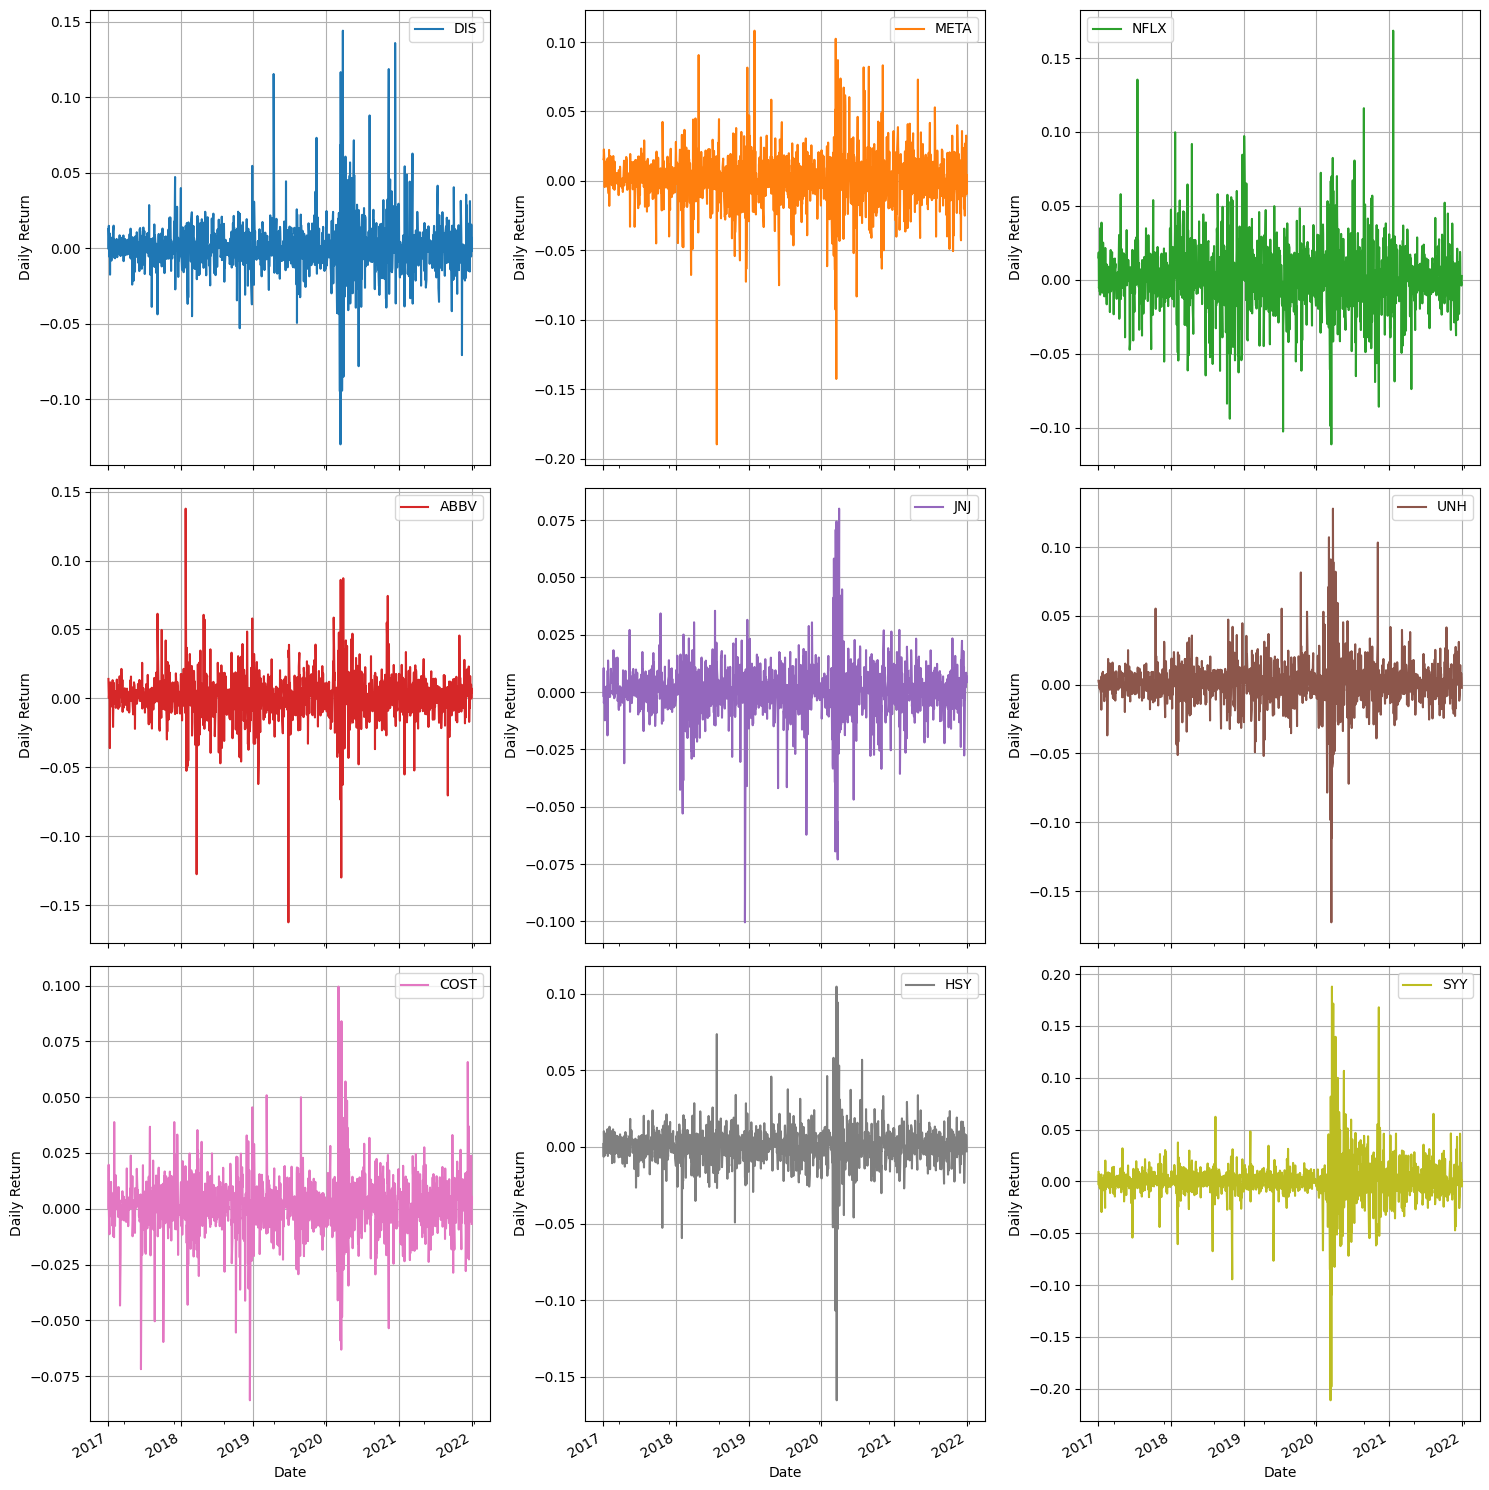

In [ ]:
#Plot of Date vs Daily Return for all stocks
return_data.plot(subplots=True,
        grid=True,
        xlabel = 'Date',
        ylabel = 'Daily Return',
        layout=(3,3),
         figsize=(15,15))
plt.tight_layout()
plt.show()

### 1.2.1 Visualization of Communication Services Sector


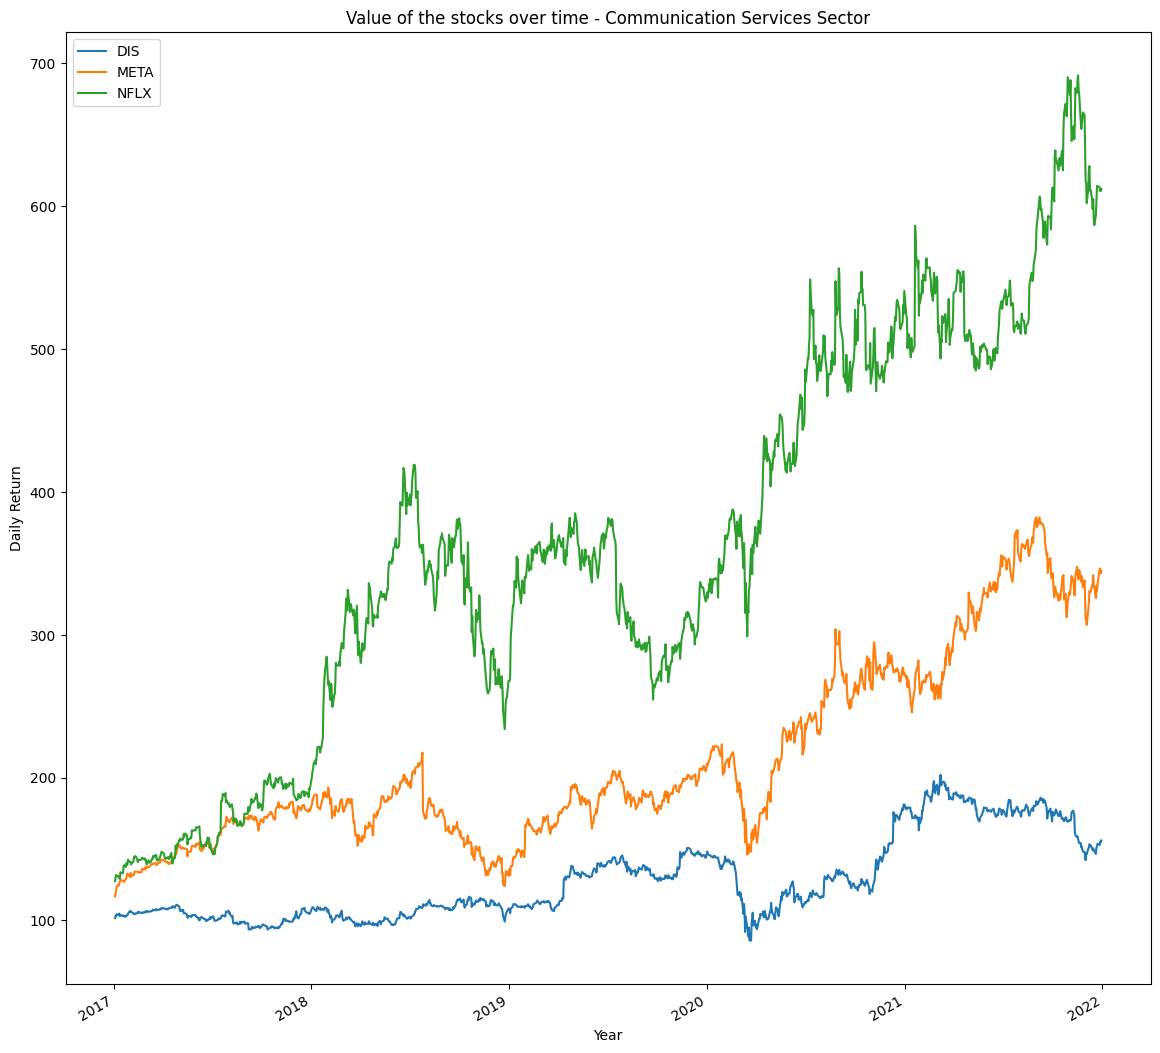

In [ ]:
prep_data_Commser = prep_data.loc[:,['DIS','META','NFLX']]
prep_data_Commser.plot(figsize=(14,14))
plt.xlabel('Year')
plt.ylabel('Daily Return')
plt.title('Value of the stocks over time - Communication Services Sector')
plt.show()


### 1.2.2 Visualization of Healthcare Sector


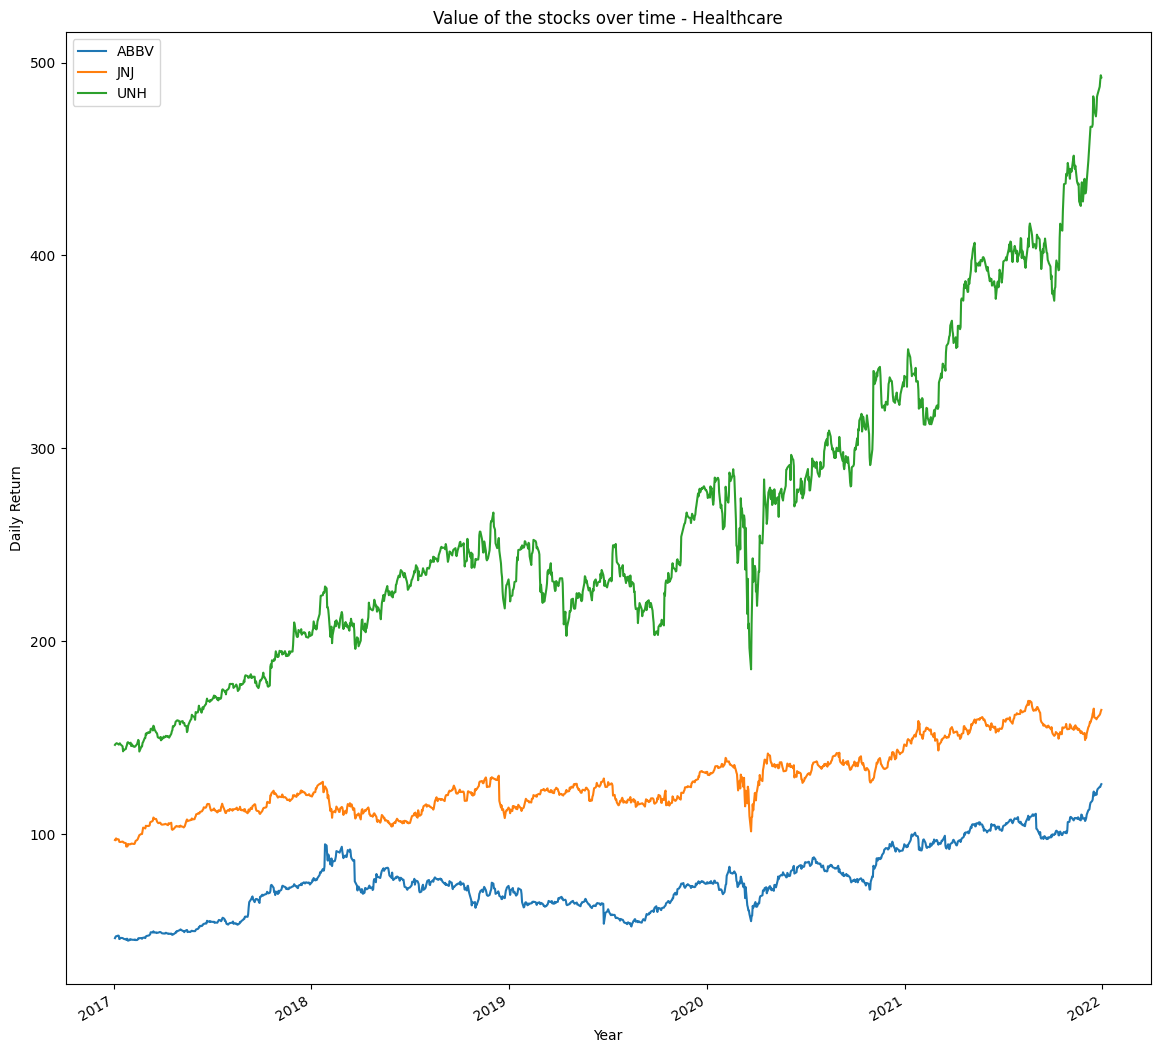

In [ ]:
prep_data_Commser = prep_data.loc[:,['ABBV','JNJ','UNH']]
prep_data_Commser.plot(figsize=(14,14))
plt.xlabel('Year')
plt.ylabel('Daily Return')
plt.title('Value of the stocks over time - Healthcare')
plt.show()

### 1.2.3 Visualization of Consumer Staples Sector


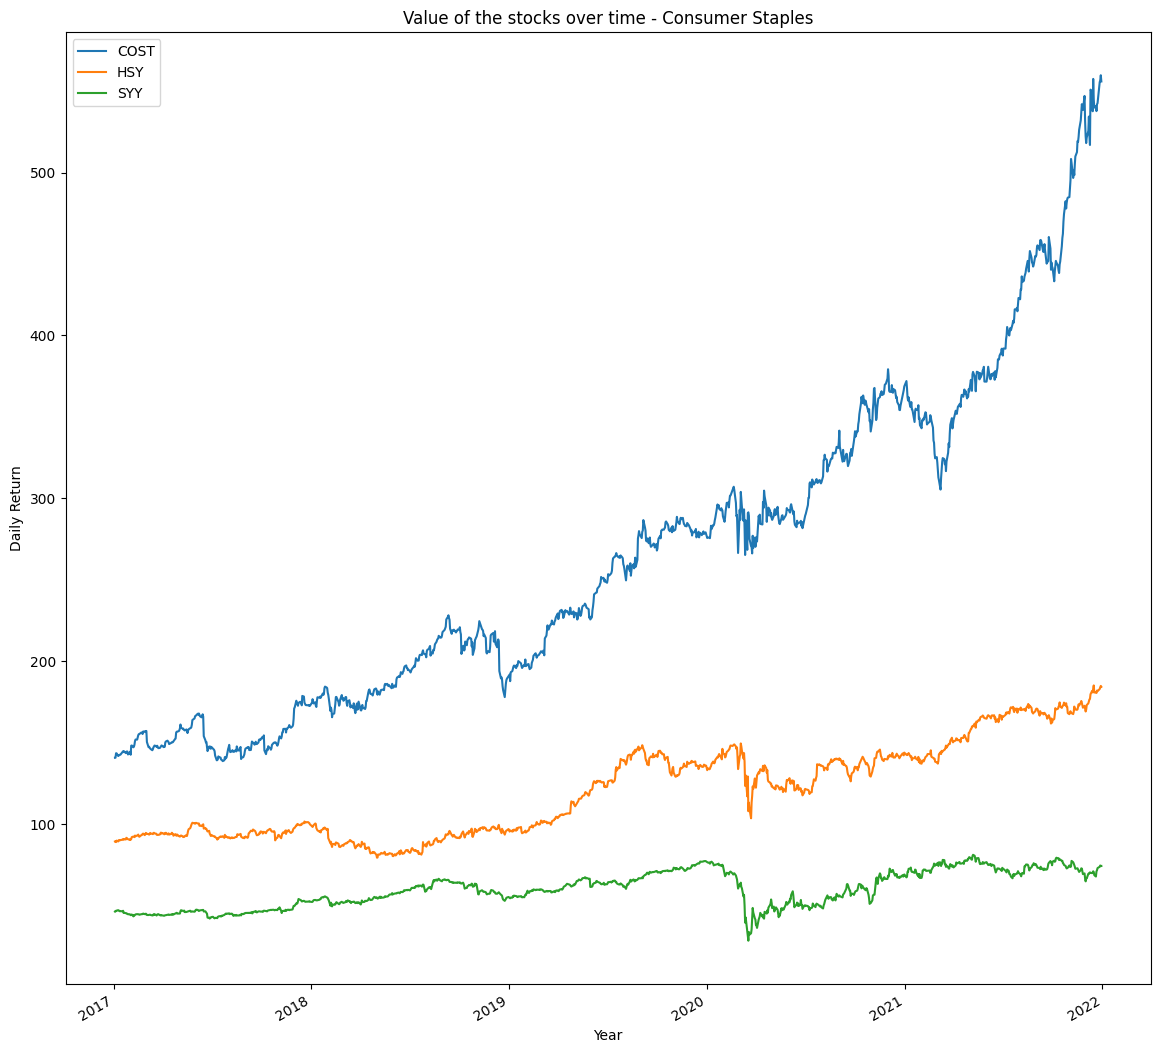

In [ ]:
prep_data_Commser = prep_data.loc[:,['COST','HSY','SYY']]
prep_data_Commser.plot(figsize=(14,14))
plt.xlabel('Year')
plt.ylabel('Daily Return')
plt.title('Value of the stocks over time - Consumer Staples')
plt.show()

## 1.3 - Discussion of the Plots

From the above plots, we can observe that -

In the Communication Sector, among the three stocks, Netflix has the highest daily returns compared to Disney and META. Though Netflix has many fluctuations, it has high daily returns after 2020.

In the Healthcare Sector, among the three stocks, United Health Group has the highest daily returns compared to Abbvie and Johnson & Johnson. The daily returns of United Health Care has  increased after 2020 till 2022.

In the Consumer Staples Sector, among the three stocks, Costco has the highest daily returns compared to the Hershey's and Sysco. The daily returns of Costco has drastically increased from 2019 till 2022.

# 2 - Optimization Model



Finding the optimal values to maximize the objective function

## 2.1 Model execution

In [ ]:
# Storing return data in df data frame
df = return_data
df.head()

,DIS,META,NFLX,ABBV,JNJ,UNH,COST,HSY,SYY
2017-01-04,0.012820,0.015660,0.015060,0.014100,-0.001640,0.002850,0.000188,0.001925,0.009146
2017-01-05,-0.000558,0.016682,0.018546,0.007584,0.010463,0.001667,0.019717,-0.006435,-0.003263
2017-01-06,0.014900,0.022707,-0.005614,0.000313,-0.004792,0.001418,-0.000491,0.010247,0.007092
2017-01-09,-0.005689,0.012074,-0.000916,0.006584,-0.000172,-0.002832,-0.011423,-0.005932,0.005417
2017-01-10,0.000184,-0.004404,-0.008095,-0.002180,-0.001032,-0.002285,0.004286,0.009048,-0.006286


## 2.2 Plot with allocation of the stocks

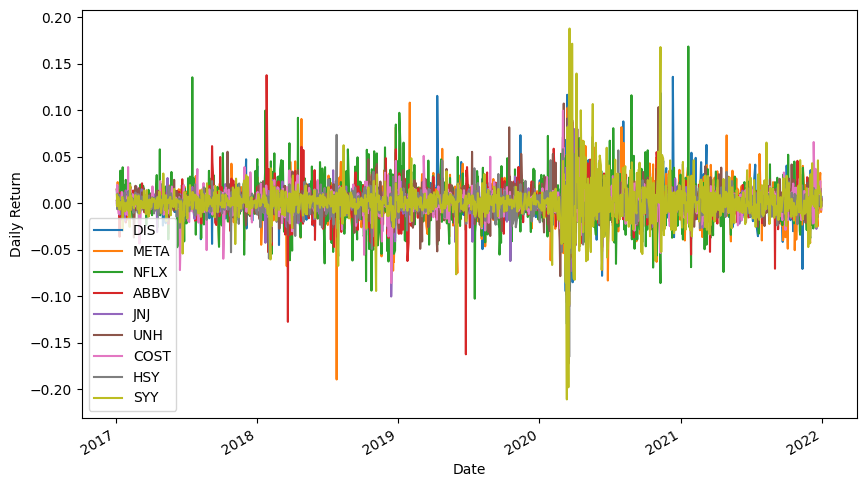

In [ ]:
# Visualization of daily return of all 9 stocks
df.plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

## 2.3 Plot with efficient frontier


In [ ]:
# Mean and Standard Deviation of each stock's return
Avg_Return = pd.DataFrame(np.mean(df),columns = ['Avg_Return'])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(df),columns = ['Std_Dev_Return'])
print(Std_Dev_Return)


      Avg_Return
DIS     0.000506
META    0.001080
NFLX    0.001536
ABBV    0.000959
JNJ     0.000501
UNH     0.001128
COST    0.001186
HSY     0.000676
SYY     0.000637
      Std_Dev_Return
DIS         0.018263
META        0.020880
NFLX        0.024032
ABBV        0.017607
JNJ         0.012618
UNH         0.017929
COST        0.013570
HSY         0.013998
SYY         0.022716


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# creating covariance table on stock return dataframe
df_cov = df.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average return of each stock
df_return = df.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           DIS      META      NFLX      ABBV       JNJ       UNH      COST  \
DIS   0.000334  0.000136  0.000100  0.000096  0.000082  0.000130  0.000074   
META  0.000136  0.000436  0.000246  0.000120  0.000081  0.000145  0.000104   
NFLX  0.000100  0.000246  0.000578  0.000099  0.000071  0.000129  0.000116   
ABBV  0.000096  0.000120  0.000099  0.000310  0.000100  0.000149  0.000074   
JNJ   0.000082  0.000081  0.000071  0.000100  0.000159  0.000118  0.000079   
UNH   0.000130  0.000145  0.000129  0.000149  0.000118  0.000322  0.000102   
COST  0.000074  0.000104  0.000116  0.000074  0.000079  0.000102  0.000184   
HSY   0.000088  0.000057  0.000058  0.000073  0.000081  0.000115  0.000081   
SYY   0.000226  0.000129  0.000073  0.000117  0.000081  0.000175  0.000086   

           HSY       SYY  
DIS   0.000088  0.000226  
META  0.000057  0.000129  
NFLX  0.000058  0.000073  
ABBV  0.000073  0.000117  
JNJ   0.000081  0.000081  
UNH   0.000115  0.000175  
COST  0.000

In [ ]:
# Run the model
from pyomo.environ import *
m = ConcreteModel()

# defining variables per stock
m.DIS = Var(within=NonNegativeReals, bounds=(0,1))
m.META = Var(within=NonNegativeReals, bounds=(0,1))
m.NFLX = Var(within=NonNegativeReals, bounds=(0,1))
m.ABBV = Var(within=NonNegativeReals, bounds=(0,1))
m.JNJ = Var(within=NonNegativeReals, bounds=(0,1))
m.UNH = Var(within=NonNegativeReals, bounds=(0,1))
m.COST = Var(within=NonNegativeReals, bounds=(0,1))
m.HSY = Var(within=NonNegativeReals, bounds=(0,1))
m.SYY = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# declare objective with maximizing returns
m.objective = Objective(expr =
                        m.DIS*df_return[0] +
                        m.META*df_return[1] +
                        m.NFLX*df_return[2] +
                        m.ABBV*df_return[3] +
                        m.JNJ*df_return[4] +
                        m.UNH*df_return[5] +
                        m.COST*df_return[6] +
                        m.HSY*df_return[7] +
                        m.SYY*df_return[8],
                        sense=maximize)

# declare constraints
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.DIS + m.META + m.NFLX + m.ABBV + m.JNJ + m.UNH + m.COST + m.HSY + m.SYY == 1)
# Set maximum risk
m.total_risk = Constraint(expr = m.DIS + m.META + m.NFLX + m.ABBV + m.JNJ + m.UNH + m.COST + m.HSY + m.SYY >= 0.0)

In [ ]:
# creating calculations table to calculate the risk
# Calculate risk
def calc_risk(m):
  variables = m.DIS, m.META, m.NFLX, m.ABBV, m.JNJ, m.UNH, m.COST, m.HSY, m.SYY
  tickers = ["DIS","META","NFLX","ABBV","JNJ", "UNH", "COST", "HSY", "SYY"]
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.01
max_risk = 0.0009
# Sequence of risk levels
risk_limits = np.arange(0.00001, max_risk, 0.000003)
risk_limits

array([1.00e-05, 1.30e-05, 1.60e-05, 1.90e-05, 2.20e-05, 2.50e-05,
       2.80e-05, 3.10e-05, 3.40e-05, 3.70e-05, 4.00e-05, 4.30e-05,
       4.60e-05, 4.90e-05, 5.20e-05, 5.50e-05, 5.80e-05, 6.10e-05,
       6.40e-05, 6.70e-05, 7.00e-05, 7.30e-05, 7.60e-05, 7.90e-05,
       8.20e-05, 8.50e-05, 8.80e-05, 9.10e-05, 9.40e-05, 9.70e-05,
       1.00e-04, 1.03e-04, 1.06e-04, 1.09e-04, 1.12e-04, 1.15e-04,
       1.18e-04, 1.21e-04, 1.24e-04, 1.27e-04, 1.30e-04, 1.33e-04,
       1.36e-04, 1.39e-04, 1.42e-04, 1.45e-04, 1.48e-04, 1.51e-04,
       1.54e-04, 1.57e-04, 1.60e-04, 1.63e-04, 1.66e-04, 1.69e-04,
       1.72e-04, 1.75e-04, 1.78e-04, 1.81e-04, 1.84e-04, 1.87e-04,
       1.90e-04, 1.93e-04, 1.96e-04, 1.99e-04, 2.02e-04, 2.05e-04,
       2.08e-04, 2.11e-04, 2.14e-04, 2.17e-04, 2.20e-04, 2.23e-04,
       2.26e-04, 2.29e-04, 2.32e-04, 2.35e-04, 2.38e-04, 2.41e-04,
       2.44e-04, 2.47e-04, 2.50e-04, 2.53e-04, 2.56e-04, 2.59e-04,
       2.62e-04, 2.65e-04, 2.68e-04, 2.71e-04, 2.74e-04, 2.77e

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# Updating risk contraint for each limit and then solving the problem
param_analysis_dict = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
#for r in [10]:
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # Run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  result = result.write()

  # Store our allocation proportions
  param_analysis_dict[r] = [m.DIS(), m.META(), m.NFLX(), m.ABBV(), m.JNJ(), m.UNH(), m.COST(), m.HSY(), m.SYY()]
  # Store our returns
  returns[r] =  m.DIS()*df_return[0] + m.META()*df_return[1] + m.NFLX()*df_return[2] + m.ABBV()*df_return[3] + m.JNJ()*df_return[4] + m.UNH()*df_return[5] + m.COST()*df_return[6] + m.HSY()*df_return[7] + m.SYY()*df_return[8]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

Streaming output truncated to the last 5000 lines.
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.012787342071533203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# -----------------------

In [ ]:
print(param_analysis_dict)

{0.000106: [0.06930159485080424, 0.033618422632782294, 0.04441481992195904, 0.09682027298008367, 0.2621527386938292, 2.900118077010374e-06, 0.2725328346924572, 0.2211506270406563, 5.7890693510215905e-06], 0.000109: [0.04659415373396552, 0.0352338633378336, 0.06602767947328862, 0.1174445049272272, 0.18985622611555922, 1.1373247310955136e-05, 0.3359305105068008, 0.2088959780728151, 5.71058519906691e-06], 0.000112: [0.033553844494205794, 0.03548035299383756, 0.07756775927517966, 0.12740173682287273, 0.14872462677939385, 0.006426269657355999, 0.37003948464832387, 0.20078587816116847, 2.0047167662116036e-05], 0.000115: [0.023146569180315258, 0.034680640634002044, 0.08550618845037747, 0.13260621291118643, 0.11649211498755159, 0.020835923353150824, 0.39391121323911765, 0.1927644670371167, 5.6670207182102296e-05], 0.000118: [0.0142071718081139, 0.03398559104423467, 0.0923457281299522, 0.13708469053474398, 0.08866010666576604, 0.03334788116027743, 0.41449746490139316, 0.18584918691687421, 2.217

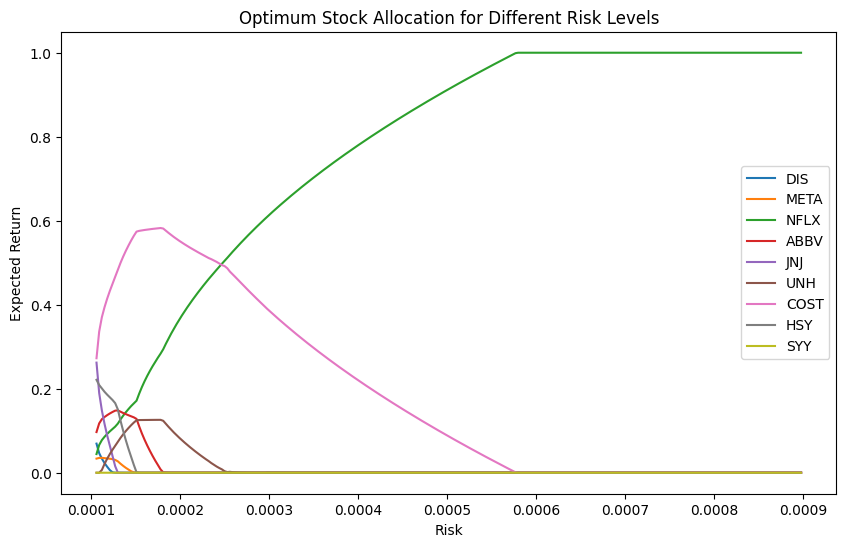

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis_dict, orient='index')
param_analysis.columns = [ 'DIS', 'META', 'NFLX', 'ABBV', 'JNJ', 'UNH', 'COST', 'HSY', 'SYY']
param_analysis.plot(figsize = (10,6))
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.title('Optimum Stock Allocation for Different Risk Levels')
plt.show()

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward)

[0.000106, 0.000109, 0.000112, 0.000115, 0.000118, 0.000121, 0.000124, 0.000127, 0.00013000000000000002, 0.000133, 0.000136, 0.000139, 0.000142, 0.000145, 0.000148, 0.000151, 0.000154, 0.000157, 0.00016, 0.000163, 0.000166, 0.00016900000000000002, 0.000172, 0.000175, 0.00017800000000000002, 0.000181, 0.000184, 0.000187, 0.00019, 0.000193, 0.000196, 0.000199, 0.000202, 0.000205, 0.00020800000000000001, 0.000211, 0.000214, 0.00021700000000000002, 0.00022, 0.000223, 0.000226, 0.000229, 0.000232, 0.000235, 0.000238, 0.000241, 0.000244, 0.00024700000000000004, 0.00025, 0.000253, 0.00025600000000000004, 0.000259, 0.000262, 0.00026500000000000004, 0.000268, 0.00027100000000000003, 0.00027400000000000005, 0.000277, 0.00028000000000000003, 0.00028300000000000005, 0.000286, 0.00028900000000000003, 0.00029200000000000005, 0.000295, 0.00029800000000000003, 0.00030100000000000005, 0.000304, 0.00030700000000000004, 0.00031000000000000005, 0.000313, 0.00031600000000000004, 0.00031900000000000006, 0.0

In [ ]:
print(param_analysis.keys())

Index(['DIS', 'META', 'NFLX', 'ABBV', 'JNJ', 'UNH', 'COST', 'HSY', 'SYY'], dtype='object')


In [ ]:
print(param_analysis.head(30))

               DIS      META      NFLX      ABBV       JNJ       UNH  \
0.000106  0.069302  0.033618  0.044415  0.096820  0.262153  0.000003   
0.000109  0.046594  0.035234  0.066028  0.117445  0.189856  0.000011   
0.000112  0.033554  0.035480  0.077568  0.127402  0.148725  0.006426   
0.000115  0.023147  0.034681  0.085506  0.132606  0.116492  0.020836   
0.000118  0.014207  0.033986  0.092346  0.137085  0.088660  0.033348   
0.000121  0.006244  0.033351  0.098457  0.141084  0.063792  0.044513   
0.000124  0.001044  0.032319  0.104188  0.144650  0.039862  0.054713   
0.000127  0.000141  0.030494  0.109765  0.147804  0.015469  0.064126   
0.000130  0.000046  0.027110  0.116995  0.148456  0.000218  0.073490   
0.000133  0.000008  0.021425  0.126923  0.145172  0.000013  0.082964   
0.000136  0.000006  0.016285  0.135893  0.142160  0.000008  0.091490   
0.000139  0.000006  0.011592  0.144103  0.139396  0.000006  0.099295   
0.000142  0.000013  0.007396  0.151689  0.136787  0.000015  0.10

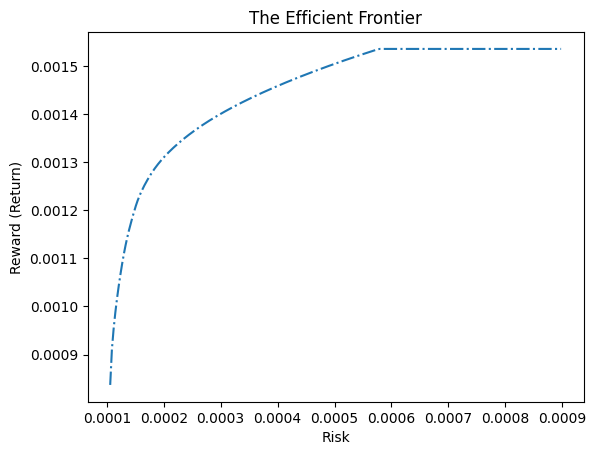

In [ ]:
# Plot of Expected Return for the given Risk
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

## 2.4 Portfolio selection

In [ ]:
# Printing all portfolios for 0.018% risk level
print(param_analysis.loc[0.000184])

DIS     0.000005
META    0.000025
NFLX    0.307124
ABBV    0.000541
JNJ     0.000006
UNH     0.116246
COST    0.576036
HSY     0.000010
SYY     0.000007
Name: 0.000184, dtype: float64


In [ ]:
# Selecting 3 portfolios from the above risk level allocations
selection_pf=param_analysis.loc[0.000184, ['NFLX', 'UNH', 'COST']]
selection_pf = pd.DataFrame({'Allocation': selection_pf})
selection_pf

,Allocation
NFLX,0.307124
UNH,0.116246
COST,0.576036


# 3 - Analyis

## 3.1 - Buy-and-Hold strategy for the MPT portfolio

*** Monthly Interval ***

In [ ]:
# Defining the ticker symbols from the optimized model
tickerlst = ["NFLX", "UNH", "COST"]

# Defining the date ranges
start_date = '2022/01/01'
end_date = '2022/12/02'

# Extracting the historical data for each ticker
dfs = {ticker: si.get_data(ticker,start_date = start_date,end_date=end_date,interval='1mo') for ticker in tickerlst}
dfs

{'NFLX':                   open        high         low       close    adjclose  \
 2022-01-01  605.609985  609.989990  351.459991  427.140015  427.140015   
 2022-02-01  432.959991  458.480011  354.720001  394.519989  394.519989   
 2022-03-01  391.600006  396.500000  329.820007  374.589996  374.589996   
 2022-04-01  376.799988  396.019989  185.600006  190.360001  190.360001   
 2022-05-01  191.710007  204.380005  162.710007  197.440002  197.440002   
 2022-06-01  198.699997  207.380005  164.279999  174.869995  174.869995   
 2022-07-01  176.490005  230.750000  169.699997  224.899994  224.899994   
 2022-08-01  223.100006  251.990005  218.740005  223.559998  223.559998   
 2022-09-01  220.720001  250.490005  214.690002  235.440002  235.440002   
 2022-10-01  237.850006  305.630005  211.729996  291.880005  291.880005   
 2022-11-01  296.170013  312.709991  252.089996  305.529999  305.529999   
 2022-12-01  303.989990  332.720001  273.410004  294.880005  294.880005   
 
               

In [ ]:
# Appending close column with its respective ticker
dfm = pd.DataFrame()
for i in tickerlst:
  dfm[i] = pd.DataFrame(dfs[i]['close'])
dfm.columns = ['NFLX_close', 'UNH_close', 'COST_close']
dfm.head()

,NFLX_close,UNH_close,COST_close
2022-01-01,427.140015,472.570007,505.130005
2022-02-01,394.519989,475.869995,519.250000
2022-03-01,374.589996,509.970001,575.849976
2022-04-01,190.360001,508.549988,531.719971
2022-05-01,197.440002,496.779999,466.220001


In [ ]:
# Applying log to close
dfm['NFLX_logClose'] = np.log(dfm['NFLX_close'])
dfm['COST_logClose'] = np.log(dfm['COST_close'])
dfm['UNH_logClose'] = np.log(dfm['UNH_close'])
dfm.head()

,NFLX_close,UNH_close,COST_close,NFLX_logClose,COST_logClose,UNH_logClose
2022-01-01,427.140015,472.570007,505.130005,6.057112,6.224816,6.158186
2022-02-01,394.519989,475.869995,519.250000,5.977670,6.252385,6.165145
2022-03-01,374.589996,509.970001,575.849976,5.925832,6.355847,6.234352
2022-04-01,190.360001,508.549988,531.719971,5.248917,6.276117,6.231564
2022-05-01,197.440002,496.779999,466.220001,5.285435,6.144658,6.208147


In [ ]:
# Calculating the returns for each stock
dfm['NFLX_return'] = dfm['NFLX_logClose'].diff()
dfm['COST_return'] = dfm['COST_logClose'].diff()
dfm['UNH_return'] = dfm['UNH_logClose'].diff()
dfm.head()

,NFLX_close,UNH_close,COST_close,NFLX_logClose,COST_logClose,UNH_logClose,NFLX_return,COST_return,UNH_return
2022-01-01,427.140015,472.570007,505.130005,6.057112,6.224816,6.158186,NaN,NaN,NaN
2022-02-01,394.519989,475.869995,519.250000,5.977670,6.252385,6.165145,-0.079442,0.027570,0.006959
2022-03-01,374.589996,509.970001,575.849976,5.925832,6.355847,6.234352,-0.051838,0.103462,0.069207
2022-04-01,190.360001,508.549988,531.719971,5.248917,6.276117,6.231564,-0.676915,-0.079730,-0.002788
2022-05-01,197.440002,496.779999,466.220001,5.285435,6.144658,6.208147,0.036518,-0.131459,-0.023416


In [ ]:
# Making value with Nan to 0
dfm['NFLX_return'].iloc[0] = 0.0
dfm['COST_return'].iloc[0] = 0.0
dfm['UNH_return'].iloc[0] = 0.0
print(dfm.head())

            NFLX_close   UNH_close  COST_close  NFLX_logClose  COST_logClose  \
2022-01-01  427.140015  472.570007  505.130005       6.057112       6.224816   
2022-02-01  394.519989  475.869995  519.250000       5.977670       6.252385   
2022-03-01  374.589996  509.970001  575.849976       5.925832       6.355847   
2022-04-01  190.360001  508.549988  531.719971       5.248917       6.276117   
2022-05-01  197.440002  496.779999  466.220001       5.285435       6.144658   

            UNH_logClose  NFLX_return  COST_return  UNH_return  
2022-01-01      6.158186     0.000000     0.000000    0.000000  
2022-02-01      6.165145    -0.079442     0.027570    0.006959  
2022-03-01      6.234352    -0.051838     0.103462    0.069207  
2022-04-01      6.231564    -0.676915    -0.079730   -0.002788  
2022-05-01      6.208147     0.036518    -0.131459   -0.023416  


In [ ]:
df_log = dfm[['NFLX_return', 'COST_return', 'UNH_return']]
df_log.head()

,NFLX_return,COST_return,UNH_return
2022-01-01,0.000000,0.000000,0.000000
2022-02-01,-0.079442,0.027570,0.006959
2022-03-01,-0.051838,0.103462,0.069207
2022-04-01,-0.676915,-0.079730,-0.002788
2022-05-01,0.036518,-0.131459,-0.023416


Calculating profit/loss for the invested anount for the assessts based on the weights from their portfolio

In [ ]:
startinginvestment = 100000
wghts = [0.307124,0.576036, 0.116246]
df_log.loc["2022-01-01"] =  [(i*startinginvestment)-1 for i in wghts]

<ipython-input-34-154e63fc566c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log.loc["2022-01-01"] =  [(i*startinginvestment)-1 for i in wghts]


Calculating cumulative return till the date

In [ ]:
Monthly_BH_Values = (1 + df_log).cumprod()
Monthly_BH_Values

,NFLX_return,COST_return,UNH_return
2022-01-01,30712.400000,57603.600000,11624.600000
2022-02-01,28272.543848,59191.710008,11705.493241
2022-03-01,26806.959538,65315.785245,12515.597716
2022-04-01,8660.924772,60108.145420,12480.699377
2022-05-01,8977.202116,52206.367600,12188.448258
2022-06-01,7887.442133,53648.691027,12595.004940
2022-07-01,9872.025260,60177.128135,13280.047122
2022-08-01,9813.029955,58003.858979,12704.309159
2022-09-01,10321.112248,52185.592754,12349.834781
2022-10-01,12538.981600,55319.482400,13518.138296


## 3.2 - Momentum trading strategy for each stock in the MPT portfolio (8-21)

In [ ]:
# Downloading the data for the tickers
# Define the ticker symbols from the optimized model
tickerlst = ["NFLX", "UNH", "COST"]

# Defining the date ranges
start_date = '2021/12/02'
end_date = '2022/12/02'

# Get the historical prices for each ticker symbol
df_mpt_down = {ticker: si.get_data(ticker,start_date = start_date,end_date=end_date,interval='1d') for ticker in tickerlst}

In [ ]:
# Appending close column with its respective ticker
df_mpt = pd.DataFrame()
for i in tickerlst:
  df_mpt[i] = pd.DataFrame(df_mpt_down[i]['close'])
df_mpt.columns = ['NFLX_close', 'UNH_close', 'COST_close']
df_mpt.head()

,NFLX_close,UNH_close,COST_close
2021-12-02,616.469971,446.019989,525.510010
2021-12-03,602.130005,449.320007,528.929993
2021-12-06,612.690002,460.109985,533.200012
2021-12-07,625.580017,464.730011,542.020020
2021-12-08,628.080017,468.859985,530.109985


In [ ]:
df_mpt.shape

(252, 3)

In [ ]:
# With No Data Lekeage
df_mpt['NFLX-8-Day'] =df_mpt['NFLX_close'].rolling(8).mean().shift()
df_mpt['NFLX-21-Day'] =df_mpt['NFLX_close'].rolling(21).mean().shift()
df_mpt['COST-8-Day'] =df_mpt['COST_close'].rolling(8).mean().shift()
df_mpt['COST-21-Day'] =df_mpt['COST_close'].rolling(21).mean().shift()
df_mpt['UNH-8-Day'] =df_mpt['UNH_close'].rolling(8).mean().shift()
df_mpt['UNH-21-Day'] =df_mpt['UNH_close'].rolling(21).mean().shift()
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day
2021-12-02,616.469971,446.019989,525.510010,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,602.130005,449.320007,528.929993,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-06,612.690002,460.109985,533.200012,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-07,625.580017,464.730011,542.020020,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08,628.080017,468.859985,530.109985,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954


In [ ]:
#Dropping null values
df_mpt.dropna(inplace = True)
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476
...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954


In [ ]:
df_mpt.columns

Index(['NFLX_close', 'UNH_close', 'COST_close', 'NFLX-8-Day', 'NFLX-21-Day',
       'COST-8-Day', 'COST-21-Day', 'UNH-8-Day', 'UNH-21-Day'],
      dtype='object')

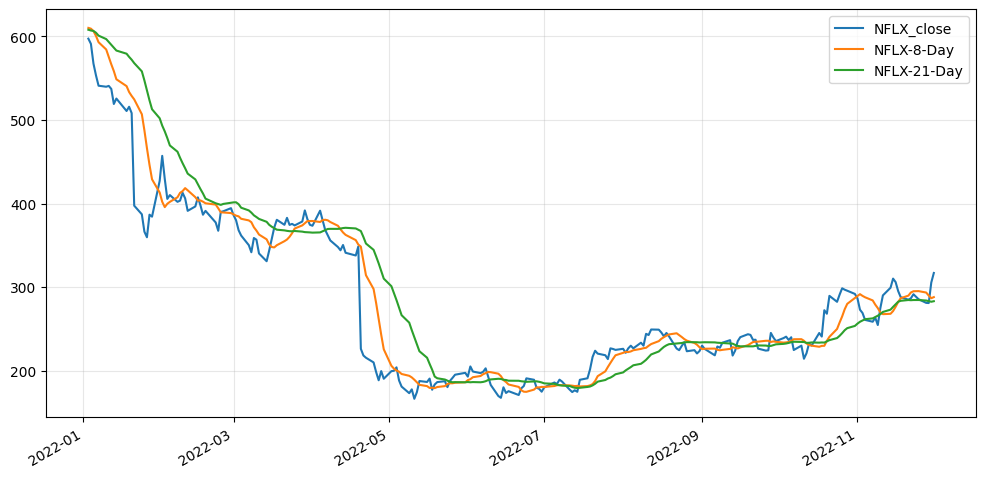

In [ ]:
# Plotting Close, 8-Day, 21-Day for NFLX
df_mpt.iloc[:,[0,3,4]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

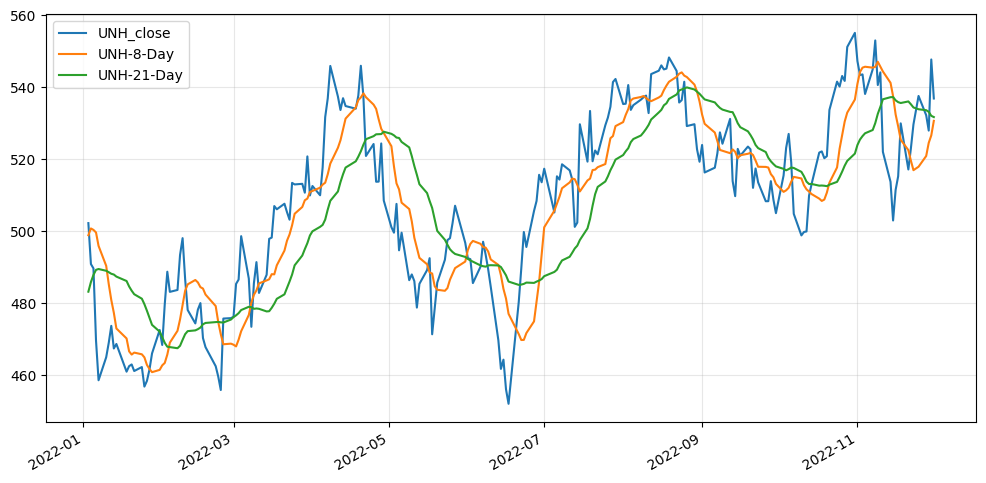

In [ ]:
# Plotting Close, 8-Day, 21-Day for UNH
df_mpt.iloc[:,[1,7,8]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

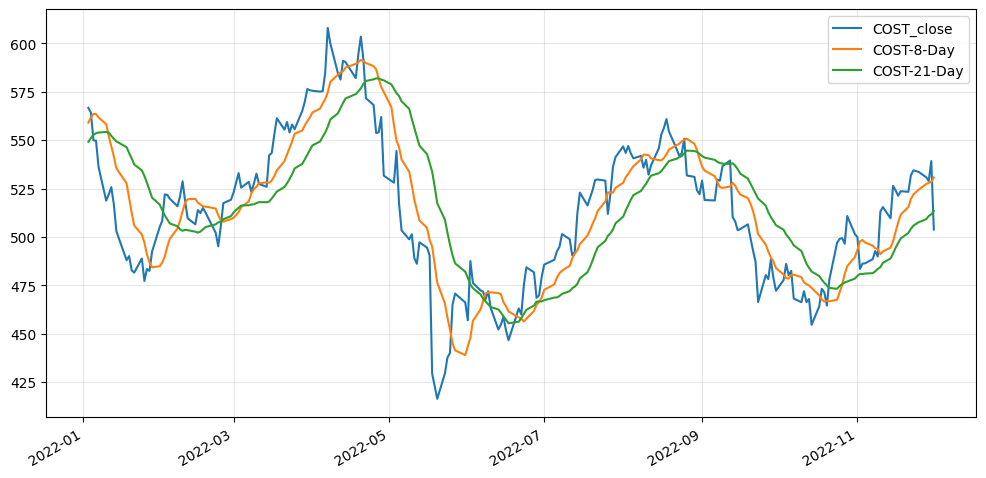

In [ ]:
# Plotting Close, 8-Day, 21-Day for COST
df_mpt.iloc[:,[2,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

In [ ]:
# Investing to stock if 8-Day is greater than 21-Day
df_mpt['NFLX_invested'] = np.where(df_mpt['NFLX-8-Day'] > df_mpt['NFLX-21-Day'], 1, 0)
df_mpt['COST_invested'] = np.where(df_mpt['COST-8-Day'] > df_mpt['COST-21-Day'], 1, 0)
df_mpt['UNH_invested'] = np.where(df_mpt['UNH-8-Day'] > df_mpt['UNH-21-Day'], 1, 0)
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,COST_invested,UNH_invested
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,1,1
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,1,1
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,1,1
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,1,1
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,1,0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,1,0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,1,0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,1,0


In [ ]:
print(df_mpt['NFLX_invested'].value_counts())
print(df_mpt['COST_invested'].value_counts())
print(df_mpt['UNH_invested'].value_counts())

0    127
1    104
Name: NFLX_invested, dtype: int64
1    132
0     99
Name: COST_invested, dtype: int64
1    125
0    106
Name: UNH_invested, dtype: int64


In [ ]:
# Signal tells buy & hold
df_mpt['NFLX_signal'] = df_mpt['NFLX_invested'].diff()
df_mpt['COST_signal'] = df_mpt['COST_invested'].diff()
df_mpt['UNH_signal'] = df_mpt['UNH_invested'].diff()
print(df_mpt['NFLX_signal'] .value_counts())
print(df_mpt['COST_signal'] .value_counts())
print(df_mpt['UNH_signal'] .value_counts())

 0.0    218
-1.0      6
 1.0      6
Name: NFLX_signal, dtype: int64
 0.0    220
-1.0      5
 1.0      5
Name: COST_signal, dtype: int64
 0.0    219
-1.0      6
 1.0      5
Name: UNH_signal, dtype: int64


In [ ]:
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,COST_invested,UNH_invested,NFLX_signal,COST_signal,UNH_signal
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,1,1,NaN,NaN,NaN
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,1,1,0.0,0.0,0.0
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,1,1,-1.0,0.0,0.0
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,1,1,0.0,0.0,0.0
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,1,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,1,0,0.0,0.0,0.0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,1,0,0.0,0.0,0.0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,1,0,0.0,0.0,0.0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,1,0,0.0,0.0,0.0


In [ ]:
# Buying on the fisrt day
# Setting row with Nan to 1 for signal
df_mpt['NFLX_signal'].iloc[0] = 1.0
df_mpt['COST_signal'].iloc[0] = 1.0
df_mpt['UNH_signal'].iloc[0] = 1.0
print(df_mpt.head())

            NFLX_close   UNH_close  COST_close  NFLX-8-Day  NFLX-21-Day  \
2022-01-03  597.369995  502.279999  566.710022  610.268753   608.041902   
2022-01-04  591.150024  490.899994  564.229980  609.325005   607.132379   
2022-01-05  567.520020  489.690002  549.919983  606.438759   606.609523   
2022-01-06  553.289978  469.649994  549.799988  600.617508   604.458572   
2022-01-07  541.059998  458.600006  536.179993  593.138756   601.016189   

            COST-8-Day  COST-21-Day   UNH-8-Day  UNH-21-Day  NFLX_invested  \
2022-01-03  559.119995   549.177141  498.913750  483.218571              1   
2022-01-04  561.779999   551.139047  500.797501  485.897619              1   
2022-01-05  563.599998   552.819999  500.393749  487.877619              0   
2022-01-06  563.543747   553.616188  499.682499  489.286191              0   
2022-01-07  561.834999   553.986662  495.951248  489.520476              0   

            COST_invested  UNH_invested  NFLX_signal  COST_signal  UNH_signal  


<ipython-input-49-b04b9dfcb3b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['NFLX_signal'].iloc[0] = 1.0
<ipython-input-49-b04b9dfcb3b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['COST_signal'].iloc[0] = 1.0
<ipython-input-49-b04b9dfcb3b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['UNH_signal'].iloc[0] = 1.0


Plotting trades for entire time series for NFLX

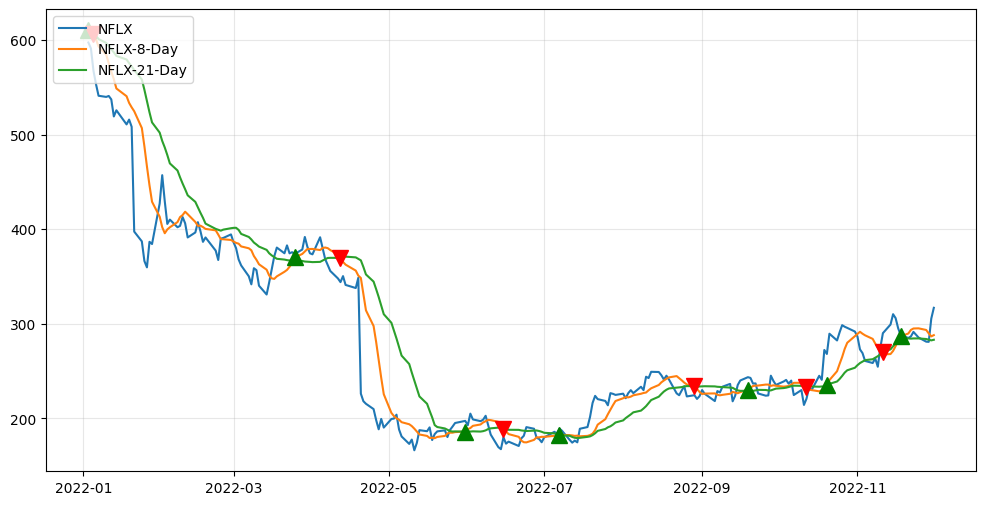

In [ ]:
# show all time
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df_mpt.iloc[:]['NFLX_close'], label = 'NFLX')
plt.plot(df_mpt.iloc[:]['NFLX-8-Day'], label = 'NFLX-8-Day')
plt.plot(df_mpt.iloc[:]['NFLX-21-Day'], label = 'NFLX-21-Day')
plt.plot(df_mpt[:].loc[df_mpt['NFLX_signal'] == 1].index, df_mpt[:]['NFLX-8-Day'][df_mpt['NFLX_signal'] == 1], '^',
         color = 'g', markersize = 12)
plt.plot(df_mpt[:].loc[df_mpt['NFLX_signal'] == -1].index, df_mpt[:]['NFLX-21-Day'][df_mpt['NFLX_signal'] == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

Plotting trades for entire time series for COST

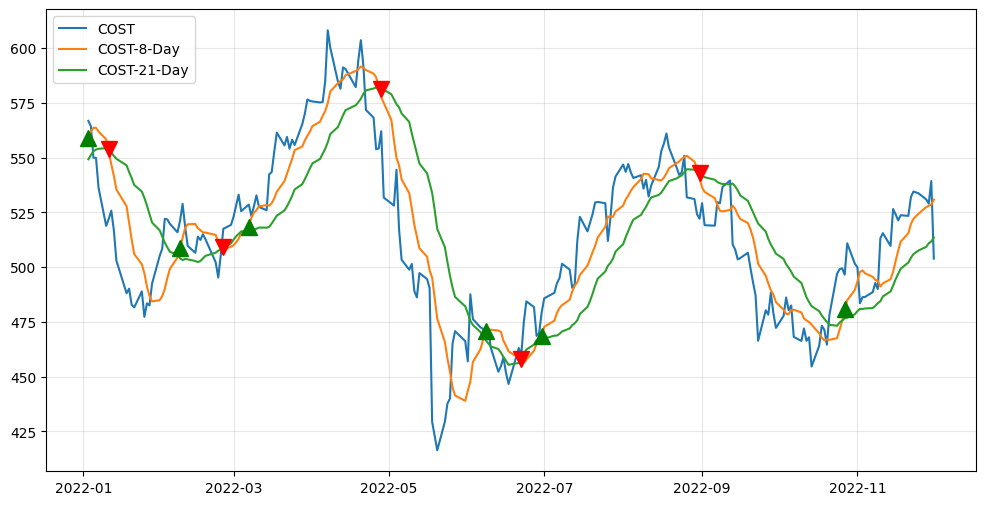

In [ ]:
# show all time
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df_mpt.iloc[:]['COST_close'], label = 'COST')
plt.plot(df_mpt.iloc[:]['COST-8-Day'], label = 'COST-8-Day')
plt.plot(df_mpt.iloc[:]['COST-21-Day'], label = 'COST-21-Day')
plt.plot(df_mpt[:].loc[df_mpt['COST_signal'] == 1].index, df_mpt[:]['COST-8-Day'][df_mpt['COST_signal'] == 1], '^',
         color = 'g', markersize = 12)
plt.plot(df_mpt[:].loc[df_mpt['COST_signal'] == -1].index, df_mpt[:]['COST-21-Day'][df_mpt['COST_signal'] == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

Plotting trades for entire time series for UNH

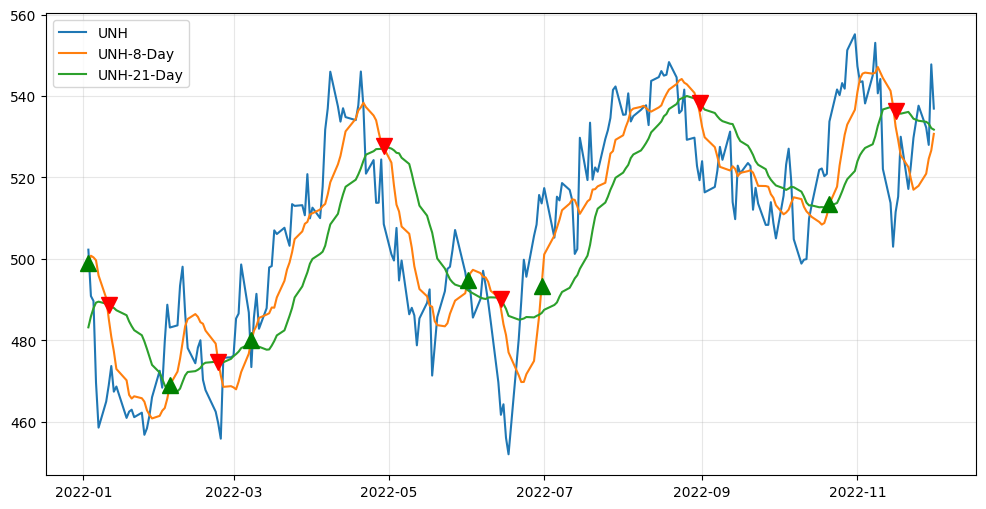

In [ ]:
# show all time
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df_mpt.iloc[:]['UNH_close'], label = 'UNH')
plt.plot(df_mpt.iloc[:]['UNH-8-Day'], label = 'UNH-8-Day')
plt.plot(df_mpt.iloc[:]['UNH-21-Day'], label = 'UNH-21-Day')
plt.plot(df_mpt[:].loc[df_mpt['UNH_signal'] == 1].index, df_mpt[:]['UNH-8-Day'][df_mpt['UNH_signal'] == 1], '^',
         color = 'g', markersize = 12)
plt.plot(df_mpt[:].loc[df_mpt['UNH_signal'] == -1].index, df_mpt[:]['UNH-21-Day'][df_mpt['UNH_signal'] == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

Calculating returns for each stock

In [ ]:
df_mpt['NFLX_return'] = np.log(df_mpt['NFLX_close']).diff()
df_mpt['COST_return'] = np.log(df_mpt['COST_close']).diff()
df_mpt['UNH_return'] = np.log(df_mpt['UNH_close']).diff()
df_mpt.head()

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,COST_invested,UNH_invested,NFLX_signal,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,1,1,1.0,1.0,1.0,NaN,NaN,NaN
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,1,1,0.0,0.0,0.0,-0.010467,-0.004386,-0.022917
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,1,1,-1.0,0.0,0.0,-0.040794,-0.025689,-0.002468
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,1,1,0.0,0.0,0.0,-0.025394,-0.000218,-0.041785
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,1,1,0.0,0.0,0.0,-0.022352,-0.025085,-0.023809


In [ ]:
df_mpt['NFLX_return'].iloc[0] = 0.0
df_mpt['COST_return'].iloc[0] = 0.0
df_mpt['UNH_return'].iloc[0] = 0.0
df_mpt.head()

<ipython-input-54-5b547fdbcb50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['NFLX_return'].iloc[0] = 0.0
<ipython-input-54-5b547fdbcb50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['COST_return'].iloc[0] = 0.0
<ipython-input-54-5b547fdbcb50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['UNH_return'].iloc[0] = 0.0


,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,COST_invested,UNH_invested,NFLX_signal,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,1,1,1.0,1.0,1.0,0.000000,0.000000,0.000000
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,1,1,0.0,0.0,0.0,-0.010467,-0.004386,-0.022917
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,1,1,-1.0,0.0,0.0,-0.040794,-0.025689,-0.002468
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,1,1,0.0,0.0,0.0,-0.025394,-0.000218,-0.041785
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,1,1,0.0,0.0,0.0,-0.022352,-0.025085,-0.023809


Calculating'system_return' which says money that might be made with Momentum Trading algorithm

In [ ]:
df_mpt['NFLX_system_return'] = df_mpt['NFLX_invested'] * df_mpt['NFLX_return']
df_mpt['COST_system_return'] = df_mpt['COST_invested'] * df_mpt['COST_return']
df_mpt['UNH_system_return'] = df_mpt['UNH_invested'] * df_mpt['UNH_return']
df_mpt.head()

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,UNH_invested,NFLX_signal,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,1,0.0,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,1,-1.0,0.0,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,1,0.0,0.0,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,1,0.0,0.0,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809


In [ ]:
df_mpt_returns = df_mpt[['NFLX_system_return','COST_system_return','UNH_system_return']]
df_mpt_returns.head()

,NFLX_system_return,COST_system_return,UNH_system_return
2022-01-03,0.000000,0.000000,0.000000
2022-01-04,-0.010467,-0.004386,-0.022917
2022-01-05,-0.000000,-0.025689,-0.002468
2022-01-06,-0.000000,-0.000218,-0.041785
2022-01-07,-0.000000,-0.025085,-0.023809


Daily to Monthly return conversion using sampling

In [ ]:
df_mpt_returns = df_mpt_returns.resample('M').sum()
df_mpt_returns.index = df_mpt_returns.index + pd.DateOffset(days=1)

Calculating monthly return for first day of every month in 2022 for $100000 investment

In [ ]:
startinginvestment = 100000
wghts = [0.307124, 0.576036, 0.116246]
new_row = [(i*startinginvestment)-1 for i in wghts]
new_index = pd.to_datetime('2022-01-01')
df_mpt_returns.loc[new_index] = new_row
df_mpt_returns = df_mpt_returns.sort_index()
startingallocation = pd.Series(wghts, index=df_mpt_returns.columns)
starting_allocation_value = startingallocation * startinginvestment
df_mpt_day1_monthly_values = (1 + df_mpt_returns).cumprod()
df_mpt_day1_monthly_values = df_mpt_day1_monthly_values.drop(df_mpt_day1_monthly_values.index[-1])
df_mpt_day1_monthly_values

,NFLX_system_return,COST_system_return,UNH_system_return
2022-01-01,30712.400000,57603.600000,11624.600000
2022-02-01,30390.938066,52515.513246,10728.107069
2022-03-01,30390.938066,51455.365023,10135.660130
2022-04-01,30300.207083,56163.375393,10605.496283
2022-05-01,28069.214805,53998.948075,10901.823972
2022-06-01,28390.924425,53998.948075,10901.823972
2022-07-01,23728.775079,54071.553678,10246.684160
2022-08-01,28483.880506,60651.448374,10804.001201
2022-09-01,28277.963468,58697.575363,10408.384398
2022-10-01,27720.199036,58697.575363,10408.384398


## 3.3 - Momentum trading strategy for the entire MPT portfolio (8-21)

Investment on all three stocks together if 8-day average is greater than 21-day average

In [ ]:
# Total Investement for all three stocks
df_mpt['Total_invested'] = np.where((df_mpt['NFLX-8-Day'] > df_mpt['NFLX-21-Day']) &
                                (df_mpt['COST-8-Day'] > df_mpt['COST-21-Day']) &
                                (df_mpt['UNH-8-Day'] > df_mpt['UNH-21-Day']), 1, 0)
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,NFLX_signal,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,-1.0,0.0,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468,0
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,0.0,0.0,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785,0
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,0.0,0.0,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,...,0.0,0.0,0.0,-0.020658,-0.001554,0.014822,-0.020658,-0.001554,0.000000,0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,...,0.0,0.0,0.0,-0.015423,-0.005148,-0.010001,-0.015423,-0.005148,-0.000000,0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,...,0.0,0.0,0.0,-0.000747,-0.003698,-0.008055,-0.000747,-0.003698,-0.000000,0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,...,0.0,0.0,0.0,0.083836,0.019266,0.036741,0.083836,0.019266,0.000000,0


In [ ]:
df_mpt[df_mpt["Total_invested"] == 1]

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,NFLX_signal,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1
2022-03-25,373.850006,513.030029,555.710022,370.123749,367.205715,553.366249,535.445235,504.872505,490.547145,1,...,1.0,0.0,0.0,-0.004963,-0.004309,-0.000838,-0.004963,-0.004309,-0.000838,1
2022-03-28,378.510010,513.200012,565.210022,373.886250,366.435239,555.040001,537.832380,506.762508,493.268098,1,...,0.0,0.0,0.0,0.012388,0.016951,0.000331,0.012388,0.016951,0.000331,1
2022-03-29,391.820007,510.730011,569.979980,376.508751,365.850002,557.767502,540.104762,508.630009,495.051432,1,...,0.0,0.0,0.0,0.034560,0.008404,-0.004825,0.034560,0.008404,-0.004825,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,260.790009,538.169983,486.410004,287.873749,261.615715,497.147503,481.133808,545.741241,527.247615,1,...,0.0,0.0,0.0,-0.031219,0.000247,-0.010058,-0.031219,0.000247,-0.010058,1
2022-11-07,258.600006,545.020020,488.549988,284.095001,262.604762,495.566254,481.320475,545.484993,528.154281,1,...,0.0,0.0,0.0,-0.008433,0.004390,0.012648,-0.008433,0.004390,0.012648,1
2022-11-08,263.459991,553.049988,492.760010,279.092503,264.216668,494.203751,482.291904,545.716248,530.067139,1,...,0.0,0.0,0.0,0.018619,0.008580,0.014626,0.018619,0.008580,0.014626,1
2022-11-09,254.660004,540.659973,489.970001,274.907501,265.810953,493.731251,483.551428,547.122498,532.647615,1,...,0.0,0.0,0.0,-0.033972,-0.005678,-0.022658,-0.033972,-0.005678,-0.022658,1


In [ ]:
print(df_mpt['Total_invested'].value_counts())

0    165
1     66
Name: Total_invested, dtype: int64


Signal calculation

In [ ]:
df_mpt['Total_signal'] = df_mpt['Total_invested'].diff()
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested,Total_signal
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,NaN
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1,0.0
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,0.0,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468,0,-1.0
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,0.0,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785,0,0.0
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,0.0,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,...,0.0,0.0,-0.020658,-0.001554,0.014822,-0.020658,-0.001554,0.000000,0,0.0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,...,0.0,0.0,-0.015423,-0.005148,-0.010001,-0.015423,-0.005148,-0.000000,0,0.0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,...,0.0,0.0,-0.000747,-0.003698,-0.008055,-0.000747,-0.003698,-0.000000,0,0.0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,...,0.0,0.0,0.083836,0.019266,0.036741,0.083836,0.019266,0.000000,0,0.0


In [ ]:
print(df_mpt['Total_signal'] .value_counts())

 0.0    221
-1.0      5
 1.0      4
Name: Total_signal, dtype: int64


In [ ]:
df_mpt['Total_signal'].iloc[0] = 0.0
df_mpt

<ipython-input-64-5389417aa5a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpt['Total_signal'].iloc[0] = 0.0


,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested,Total_signal
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.0
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1,0.0
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,0.0,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468,0,-1.0
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,0.0,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785,0,0.0
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,0.0,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,...,0.0,0.0,-0.020658,-0.001554,0.014822,-0.020658,-0.001554,0.000000,0,0.0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,...,0.0,0.0,-0.015423,-0.005148,-0.010001,-0.015423,-0.005148,-0.000000,0,0.0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,...,0.0,0.0,-0.000747,-0.003698,-0.008055,-0.000747,-0.003698,-0.000000,0,0.0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,...,0.0,0.0,0.083836,0.019266,0.036741,0.083836,0.019266,0.000000,0,0.0


In [ ]:
df_mpt[df_mpt['Total_invested'].isin([1,-1])]
df_mpt

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,COST_signal,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested,Total_signal
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.0
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1,0.0
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,0.0,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468,0,-1.0
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,0.0,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785,0,0.0
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,0.0,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,285.540009,537.619995,533.659973,295.248749,284.598572,524.382492,507.593807,517.947506,533.925713,1,...,0.0,0.0,-0.020658,-0.001554,0.014822,-0.020658,-0.001554,0.000000,0,0.0
2022-11-28,281.170013,532.270020,530.919983,293.532501,283.975715,527.379990,509.222852,520.931255,533.661428,1,...,0.0,0.0,-0.015423,-0.005148,-0.010001,-0.015423,-0.005148,-0.000000,0,0.0
2022-11-29,280.959991,528.000000,528.960022,289.903751,283.224763,527.936241,510.859994,524.588757,533.207620,1,...,0.0,0.0,-0.000747,-0.003698,-0.008055,-0.000747,-0.003698,-0.000000,0,0.0
2022-11-30,305.529999,547.760010,539.250000,286.771252,282.521906,528.542496,511.721424,526.648758,532.100954,1,...,0.0,0.0,0.083836,0.019266,0.036741,0.083836,0.019266,0.000000,0,0.0


Entire portfolio system return calculation

In [ ]:
# 'Total_System_Return' says money that might be made with Momentum Trading Algorithm
df_mpt['Total_system_return'] = df_mpt['Total_invested'] * (df_mpt['NFLX_return'] + df_mpt['COST_return'] + df_mpt['UNH_return'])
df_mpt.head()

,NFLX_close,UNH_close,COST_close,NFLX-8-Day,NFLX-21-Day,COST-8-Day,COST-21-Day,UNH-8-Day,UNH-21-Day,NFLX_invested,...,UNH_signal,NFLX_return,COST_return,UNH_return,NFLX_system_return,COST_system_return,UNH_system_return,Total_invested,Total_signal,Total_system_return
2022-01-03,597.369995,502.279999,566.710022,610.268753,608.041902,559.119995,549.177141,498.913750,483.218571,1,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.00000
2022-01-04,591.150024,490.899994,564.229980,609.325005,607.132379,561.779999,551.139047,500.797501,485.897619,1,...,0.0,-0.010467,-0.004386,-0.022917,-0.010467,-0.004386,-0.022917,1,0.0,-0.03777
2022-01-05,567.520020,489.690002,549.919983,606.438759,606.609523,563.599998,552.819999,500.393749,487.877619,0,...,0.0,-0.040794,-0.025689,-0.002468,-0.000000,-0.025689,-0.002468,0,-1.0,-0.00000
2022-01-06,553.289978,469.649994,549.799988,600.617508,604.458572,563.543747,553.616188,499.682499,489.286191,0,...,0.0,-0.025394,-0.000218,-0.041785,-0.000000,-0.000218,-0.041785,0,0.0,-0.00000
2022-01-07,541.059998,458.600006,536.179993,593.138756,601.016189,561.834999,553.986662,495.951248,489.520476,0,...,0.0,-0.022352,-0.025085,-0.023809,-0.000000,-0.025085,-0.023809,0,0.0,-0.00000


In [ ]:
Total_portfolio_monthly_values = pd.DataFrame(df_mpt["Total_system_return"].resample('M').sum())
Total_portfolio_monthly_values.index = Total_portfolio_monthly_values.index + pd.DateOffset(days=1)

In [ ]:
startinginvestment = 99999
new_row = [startinginvestment]
new_index = pd.to_datetime('2022-01-01')
Total_portfolio_monthly_values.loc[new_index] = new_row
Total_portfolio_monthly_values = Total_portfolio_monthly_values.sort_index()
starting_allocation_value = startingallocation * startinginvestment

In [ ]:
Total_portfolio_monthly_values = (1 + Total_portfolio_monthly_values).cumprod()
Total_portfolio_monthly_values = Total_portfolio_monthly_values.drop(Total_portfolio_monthly_values.index[-1])
Total_portfolio_monthly_values

,Total_system_return
2022-01-01,100000.000000
2022-02-01,96223.004017
2022-03-01,96223.004017
2022-04-01,98290.392514
2022-05-01,97704.189708
2022-06-01,97704.189708
2022-07-01,72658.257733
2022-08-01,97778.547493
2022-09-01,92955.128826
2022-10-01,92955.128826


## 3.4 - Buy-and-Hold strategy for the S&P 500 index

In [ ]:
# Download S&P 500 index data
ticker = '^GSPC'

sp500 = si.get_data(ticker,start_date = '2022/01/01',end_date='2022/12/02',interval='1mo')
sp500 = sp500[['close']]
sp500.columns = ['sp500_close']
sp500.head()

,sp500_close
2022-01-01,4515.549805
2022-02-01,4373.939941
2022-03-01,4530.410156
2022-04-01,4131.930176
2022-05-01,4132.149902


In [ ]:
sp500['sp500_logClose'] = np.log(sp500['sp500_close']) # price will always be positive
sp500['sp500_return'] = sp500['sp500_logClose'].diff() # the difference might be positive/negative
sp500.head()

,sp500_close,sp500_logClose,sp500_return
2022-01-01,4515.549805,8.415282,NaN
2022-02-01,4373.939941,8.383419,-0.031863
2022-03-01,4530.410156,8.418568,0.035148
2022-04-01,4131.930176,8.326500,-0.092068
2022-05-01,4132.149902,8.326553,0.000053


In [ ]:
sp500['sp500_return'].iloc[0]=0.0
sp500_returns = pd.DataFrame(sp500["sp500_return"])

In [ ]:
startinginvestment = 99999
sp500_returns.loc["2022-01-01"] =  [startinginvestment]
Monthly_BH_Values_SP = (1 + sp500_returns).cumprod()
Monthly_BH_Values_SP

,sp500_return
2022-01-01,100000.000000
2022-02-01,96813.723898
2022-03-01,100216.560380
2022-04-01,90989.839646
2022-05-01,90994.678149
2022-06-01,83018.850673
2022-07-01,90258.209407
2022-08-01,86343.978872
2022-09-01,77878.023701
2022-10-01,83861.747734


## 3.5 - Plot Comparing the Investment Strategies

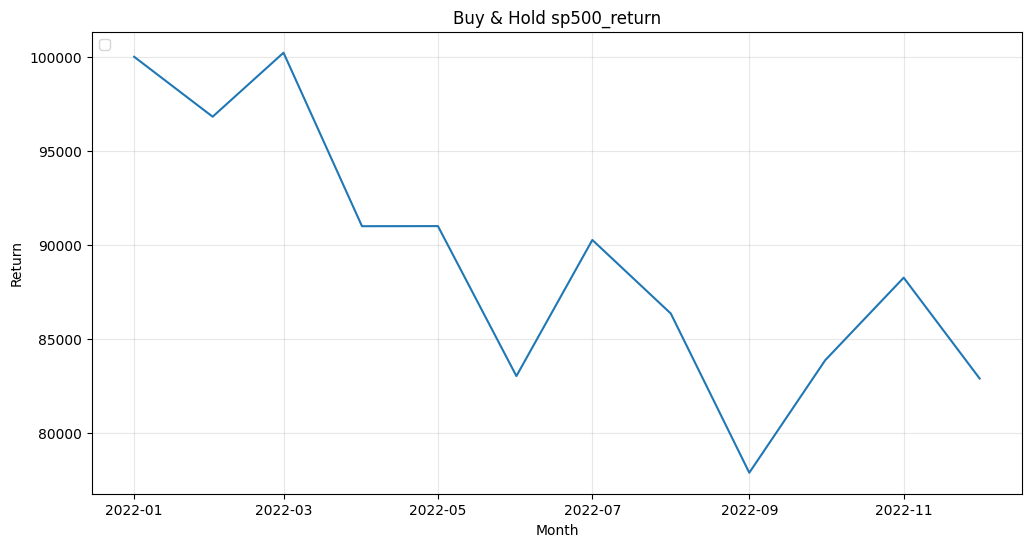

In [ ]:
import matplotlib.pyplot as plt
# Plot for sp500_return in Buy and Hold
plt.plot(Monthly_BH_Values_SP["sp500_return"])
plt.legend(loc=2)
plt.title('Buy & Hold sp500_return')
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid(True, alpha=.3)
plt.show()

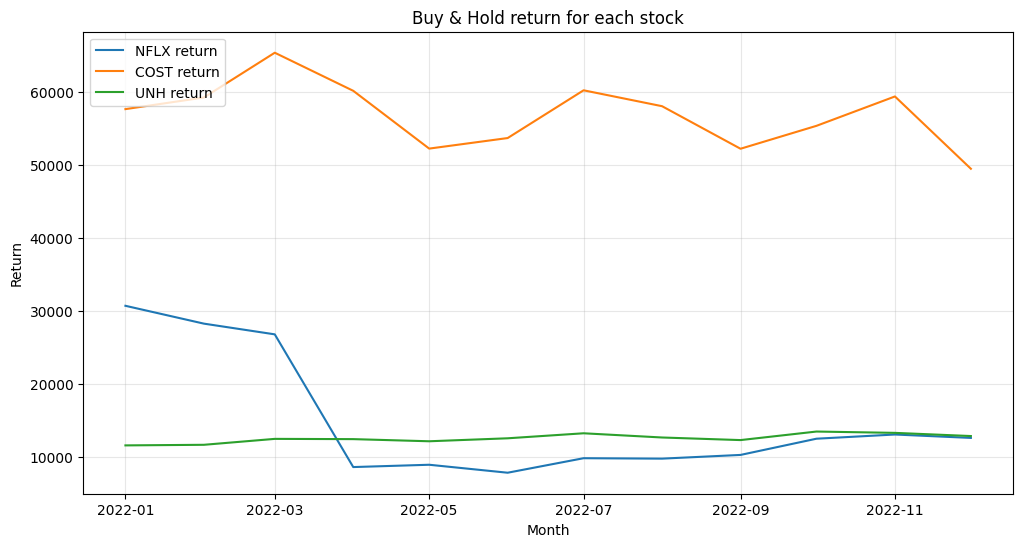

In [ ]:
# Plot for each stock return in Buy and Hold
plt.plot(Monthly_BH_Values['NFLX_return'], label='NFLX return')
plt.plot(Monthly_BH_Values['COST_return'], label='COST return')
plt.plot(Monthly_BH_Values['UNH_return'], label='UNH return')
plt.legend(loc=2)
plt.title('Buy & Hold return for each stock')
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid(True, alpha=.3)
plt.show()

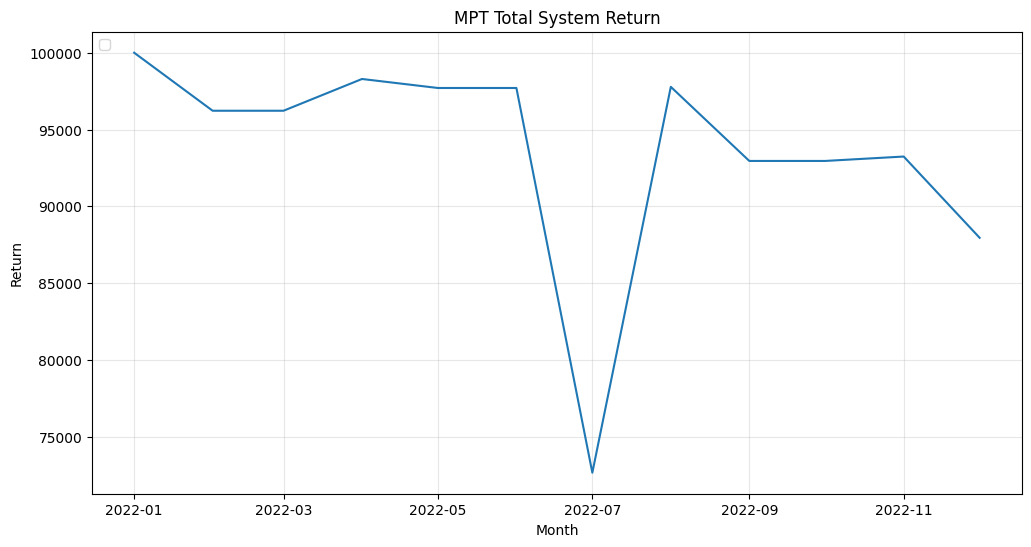

In [ ]:
# plot for entire portfolio system return in MPT
plt.plot(Total_portfolio_monthly_values["Total_system_return"])
plt.legend(loc=2)
plt.title("MPT Total System Return")
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid(True, alpha=.3)
plt.show()

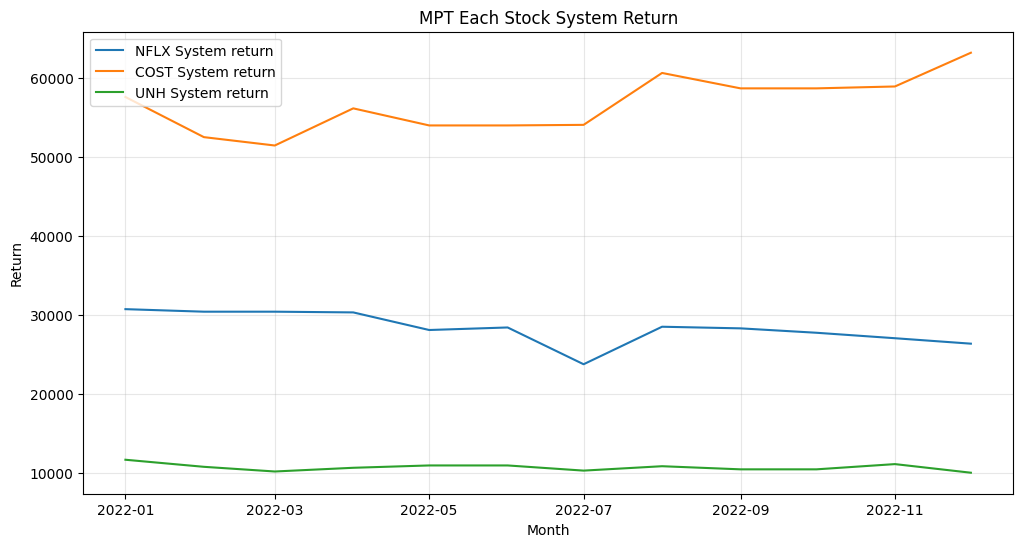

In [ ]:
# Plot for each stock system return in MPT
plt.plot(df_mpt_day1_monthly_values['NFLX_system_return'], label='NFLX System return')
plt.plot(df_mpt_day1_monthly_values['COST_system_return'], label='COST System return')
plt.plot(df_mpt_day1_monthly_values['UNH_system_return'], label='UNH System return')
plt.legend(loc=2)
plt.title('MPT Each Stock System Return')
plt.xlabel('Month')
plt.ylabel('Return')
plt.grid(True, alpha=.3)
plt.show()

Calculating Percentage changes to check which strategy is preferable

In [ ]:
# Monthly_BH_Values
BH_pct_changes = [(100 * ((Monthly_BH_Values.loc["12-01-2022", i] - Monthly_BH_Values.loc["01-01-2022", i]) / Monthly_BH_Values.loc["01-01-2022", i])) for i in Monthly_BH_Values]
for i, pct_change in enumerate(BH_pct_changes):
 print("Buy and Hold for {} percentage change: {}".format(Monthly_BH_Values.columns[i], pct_change))
print("\n")

# df_mpt_day1_monthly_values
MPT_pct_changes = [(100 * ((df_mpt_day1_monthly_values.loc["12-01-2022", i] - df_mpt_day1_monthly_values.loc["01-01-2022", i]) / df_mpt_day1_monthly_values.loc["01-01-2022", i])) for i in df_mpt_day1_monthly_values]
for i, pct_change in enumerate(MPT_pct_changes):
 print("MPT for each System {} percentage change: {}".format(df_mpt_day1_monthly_values.columns[i], pct_change))
print("\n")

# Monthly_BH_Values_SP
BH_sp500_pct_change = (100 * ((Monthly_BH_Values_SP.loc["12-01-2022", "sp500_return"] - Monthly_BH_Values_SP.loc["01-01-2022", "sp500_return"]) / Monthly_BH_Values_SP.loc["01-01-2022", "sp500_return"]))
print("Buy and Hold for S&P 500 Index percentage change: {}".format(BH_sp500_pct_change))
print("\n")

# Total_portfolio_monthly_values
MPT_total_pct_change = (100 * ((Total_portfolio_monthly_values.loc["12-01-2022", "Total_system_return"] - Total_portfolio_monthly_values.loc["01-01-2022", "Total_system_return"]) / Total_portfolio_monthly_values.loc["01-01-2022", "Total_system_return"]))
print("MPT for entire portfolio System Return percentage change: {}".format(MPT_total_pct_change))

Buy and Hold for NFLX_return percentage change: -58.821620113089644
Buy and Hold for COST_return percentage change: -14.15503483612269
Buy and Hold for UNH_return percentage change: 10.988062358619764


MPT for each System NFLX_system_return percentage change: -14.246463705737158
MPT for each System COST_system_return percentage change: 9.74222382710474
MPT for each System UNH_system_return percentage change: -14.150848958883843


Buy and Hold for S&P 500 Index percentage change: -17.11157373582489


MPT for entire portfolio System Return percentage change: -12.048058486760084


## 3.6 - Discussion and Comparison of the Investment Strategies

From the above graphs we can infer that -

1. For S&P 500, it has maximum returns in march month and in later months returs were reduced compared to the march.

2. For Buy & Hold return for each stock, COSTCO has hightest return compared to United Healthcare and Netflix. From october for Netflix and UNH, the returns are silimilar.

3. MPT for entire portfolio returns, the better returns achieved at january and the least in july. If we want maximum profit for short term, we can sell alll three stocks together in jan.

4. MPT for each stock, COSTCO has highest returns followed by Netflix followed by United Healthcare. In here for each stock in every month it has a kind of constant returns i.e., very lesser fluctuations.

From the above numerical calculations we can observe that -

1. For NFLX, Momentum Trading gives lesser loss than Buy & Hold in the entire time period of 2022 with 14%.

2. For Costco, Momentum Trading gives higher return with 9.74% compared to the Buy & Hold in 2022.

3. For UNH, Buy & hold strategy gives better returns with 10.9% compared to the Momentum Trading in 2022.

4. In overall, Momentum Trading shows better results compared to Buy and Hold.

# 4 - Conclusion

## 4.1 - Thoughts and Insights

1. Buy & Hold strategy is a long term investment strategy that is appropriate for investors who do not have time to monitor their investement portfolio on regular basis.

2. Momentum Trading is a strategy that involves buying assessts that have recently shown strong performance and selling assessts that have recently performed poorly.

3. Through efficient frontier we can analyze the risk level for different portfolios and invest in them accordingly.

4. It is always important to consider historical data rather than sticking with the current data.

5. Modern Portfolio Theory (MPT) is a algorithm for constructing portfolios that aim to maximize expected returns for a given level of risk. The primary objective of MPT is to find the optimal mix of assets that offer the highest possible expected return for a given level of risk.

6. The returns and performance varies with the different strategies and with diffrent risk levels.

7. The moving averages in the momentum trading tells the time period of when to sell and when to buy the stocks.

## 4.2 - Individual Contributions

1. Sailesh Kiran Kurra- Data Preparation (1.1-1.2) and EDA
2. Jathin Reddy Kancham - Optimization Model (2.1-2.4)
3. Lahari Maddula - Analysis (3.1-3.5) & Video Recording
4. Roopa - Discussion and comparision of Investment strategies, Discussion of the Plots, Concluion